In [49]:
import numpy as np
import pandas as pd
from pathlib import Path

%matplotlib inline

In [50]:
from numpy.random import seed
seed(1)

from tensorflow import random
random.set_seed(2)

In [51]:
# load csv into dataframe
df = pd.read_csv(
    Path('../data/stocks_history.csv'),
    index_col='Unnamed: 0',
    infer_datetime_format=True,
    parse_dates=True
)
df.head()

,MSFT_open,MSFT_high,MSFT_low,MSFT_close,AMD_open,AMD_high,AMD_low,AMD_close,TSLA_open,TSLA_high,...,JNJ_low,JNJ_close,REGN_open,REGN_high,REGN_low,REGN_close,GILD_open,GILD_high,GILD_low,GILD_close
2010-06-29,24.13,24.20,23.110,23.31,7.93,7.93,7.41,7.48,19.00,25.0000,...,58.680,59.24,23.67,23.95,22.86,22.98,35.40,35.61,34.740,34.97
2010-06-30,23.30,23.68,22.950,23.01,7.58,7.65,7.30,7.32,25.79,30.4192,...,58.940,59.06,23.05,23.47,22.32,22.32,34.83,35.13,34.260,34.28
2010-07-01,23.09,23.32,22.730,23.16,7.35,7.53,7.10,7.39,25.00,25.9200,...,58.650,59.07,22.31,22.37,20.45,20.79,34.24,34.27,33.300,34.14
2010-07-02,23.36,23.48,23.050,23.27,7.45,7.48,7.02,7.17,23.00,23.1000,...,58.850,59.08,21.06,21.88,20.75,21.61,34.38,35.16,34.180,34.87
2010-07-06,23.70,24.09,23.584,23.82,7.40,7.42,6.96,7.04,20.00,20.0000,...,58.669,59.08,22.03,22.03,21.16,21.36,35.11,35.42,34.415,34.77


In [53]:
# drop all columns except closing prices
dropped_columns = [
    'MSFT_open',
    'MSFT_high',
    'MSFT_low',
    'AMD_open',
    'AMD_high',
    'AMD_low',
    'TSLA_open',
    'TSLA_high',
    'TSLA_low',
    'JNJ_open',
    'JNJ_high',
    'JNJ_low',
    'REGN_open',
    'REGN_high',
    'REGN_low',
    'GILD_open',
    'GILD_high',
    'GILD_low'
]
df.drop(columns=dropped_columns, inplace=True)
df.head()

,MSFT_close,AMD_close,TSLA_close,JNJ_close,REGN_close,GILD_close
2010-06-29,23.31,7.48,23.89,59.24,22.98,34.97
2010-06-30,23.01,7.32,23.83,59.06,22.32,34.28
2010-07-01,23.16,7.39,21.96,59.07,20.79,34.14
2010-07-02,23.27,7.17,19.20,59.08,21.61,34.87
2010-07-06,23.82,7.04,16.11,59.08,21.36,34.77


In [54]:
df.describe()

,MSFT_close,AMD_close,TSLA_close,JNJ_close,REGN_close,GILD_close
count,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000,2523.000000
mean,63.680971,11.576498,211.349443,103.053430,302.553496,70.064921
std,42.135175,12.557261,170.826294,28.239567,154.858585,20.766248
min,23.010000,1.620000,15.800000,57.020000,20.790000,31.830000
25%,30.710000,3.650000,35.090000,71.405000,170.790000,55.555000
50%,47.000000,6.830000,218.130000,102.460000,338.150000,70.310000
75%,86.365000,13.120000,284.470000,129.655000,404.385000,80.910000
max,210.700000,58.900000,1389.860000,155.510000,643.920000,122.210000


In [55]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [56]:
# Creating the features (X) and target (y) data using the window_data() function.
window_size = 15 # iterate over this to measure accuracy change vs window size

feature_column = 0 # iterate over this to predict each stock in dataframe
target_column = 0 # iterate over this to predict each stock in dataframe
X, y = window_data(df, window_size, feature_column, target_column)

In [57]:
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split - 1]
X_test = X[split:]
y_train = y[: split - 1]
y_test = y[split:]

In [58]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [59]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [60]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [61]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 15 # should be equal to the size of the time window as selected above
dropout_fraction = 0.25 # means that each epoch will randomly drop x% - iterate over

# Layer 1
model.add(LSTM(
    units=number_units,
#     return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
# model.add(LSTM(units=number_units, return_sequences=True))
# model.add(Dropout(dropout_fraction))
# Layer 3
# model.add(LSTM(units=number_units))
# model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [62]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [63]:
# Summarize the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 15)                1020      
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 16        
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________


In [64]:
# Train the model
model.fit(X_train, y_train, epochs=30, shuffle=False, batch_size=10, verbose=1)

Train on 1753 samples
Epoch 1/30
1753/1753 [==============================] - 3s 2ms/sample - loss: 3.5870e-04
Epoch 2/30
1753/1753 [==============================] - 1s 665us/sample - loss: 7.4646e-04
Epoch 3/30
1753/1753 [==============================] - 1s 615us/sample - loss: 5.2436e-04
Epoch 4/30
1753/1753 [==============================] - 1s 623us/sample - loss: 4.1502e-04
Epoch 5/30
1753/1753 [==============================] - 1s 605us/sample - loss: 3.2726e-04
Epoch 6/30
1753/1753 [==============================] - 1s 607us/sample - loss: 2.2554e-04
Epoch 7/30
1753/1753 [==============================] - 1s 682us/sample - loss: 2.1564e-04
Epoch 8/30
1753/1753 [==============================] - 1s 697us/sample - loss: 2.1912e-04
Epoch 9/30
1753/1753 [==============================] - 1s 763us/sample - loss: 1.9206e-04
Epoch 10/30
1753/1753 [==============================] - 1s 736us/sample - loss: 1.5296e-04
Epoch 11/30
1753/1753 [==============================] - 1s 850us/sam

In [65]:
# Evaluate the model
model.evaluate(X_test, y_test)

753/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.0025431409658762723

In [66]:
# Make some predictions
predicted = model.predict(X_test)

In [67]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [68]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
})
stocks.head()

,Real,Predicted
0,69.98,67.290733
1,69.99,67.681244
2,71.15,68.016380
3,71.77,68.620903
4,72.78,69.277100


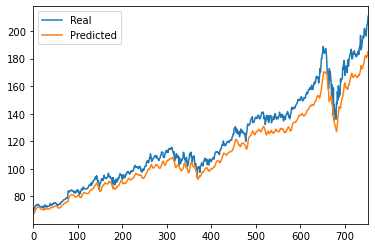

In [69]:
# Plot the real vs predicted prices as a line chart
stocks.plot()

In [70]:
stocks

,Real,Predicted
0,69.98,67.290733
1,69.99,67.681244
2,71.15,68.016380
3,71.77,68.620903
4,72.78,69.277100
5,73.35,70.065033
6,73.30,70.808601
7,73.86,71.299728
8,74.22,71.752998
9,73.79,72.127174


In [71]:
from sklearn.metrics import mean_squared_error

print(f'MSE:{mean_squared_error(stocks.iloc[:,0],stocks.iloc[:,1], squared=True)}')
print(f'RMSE:{mean_squared_error(stocks.iloc[:,0],stocks.iloc[:,1], squared=False)}')

MSE:89.1547853506907
RMSE:9.442181175485391
